### Stock Forecasting & Direction Prediction Snippet

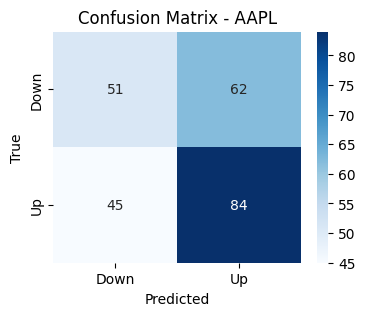

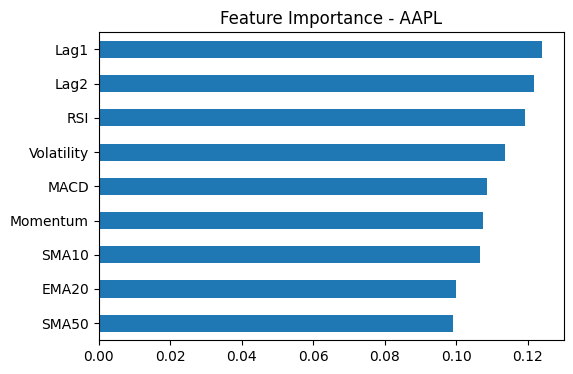

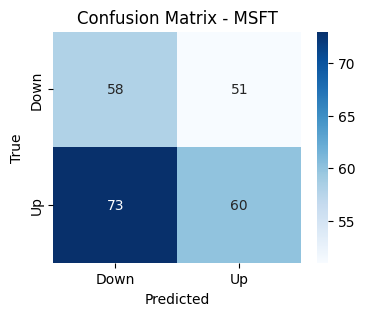

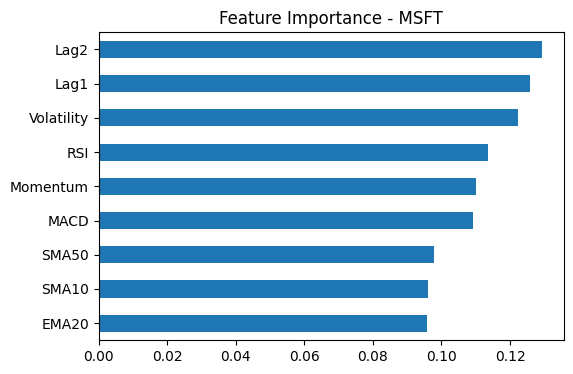

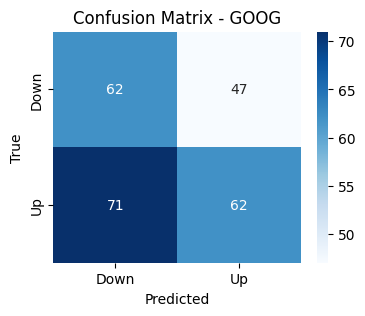

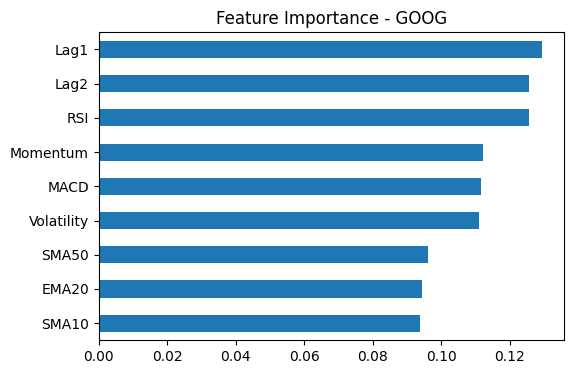

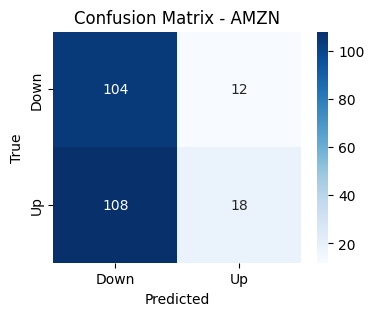

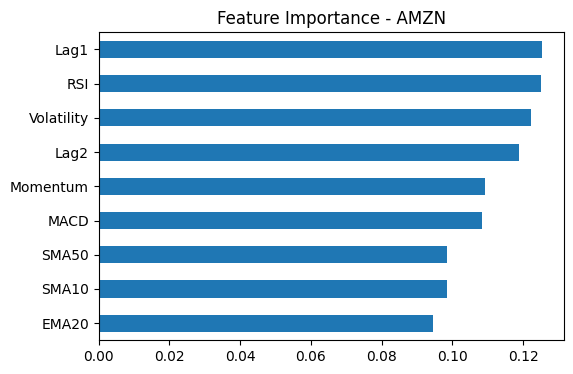

  Ticker  Accuracy
0   AAPL  0.557851
1   MSFT  0.487603
2   GOOG  0.512397
3   AMZN  0.504132


In [4]:
# ----------------------------
# Extended Multi-Ticker Random Forest Evaluation
# ----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load cleaned stock dataset
all_stocks = pd.read_csv("../data/processed/all_stocks_clean.csv")
all_stocks["Date"] = pd.to_datetime(all_stocks["Date"])

tickers = ["AAPL", "MSFT", "GOOG", "AMZN"]
results = []

for ticker in tickers:
    df = all_stocks[all_stocks["Ticker"]==ticker].copy().sort_values("Date")

    # ----------------------------
    # Feature Engineering
    # ----------------------------
    df["Return"] = df["Close"].pct_change()
    df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

    df["SMA10"] = df["Close"].rolling(10).mean()
    df["SMA50"] = df["Close"].rolling(50).mean()
    df["EMA20"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["Volatility"] = df["Return"].rolling(10).std()
    df["Momentum"] = df["SMA10"] - df["SMA50"]

    # RSI
    delta = df["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # MACD
    df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = df["EMA12"] - df["EMA26"]

    df["Lag1"] = df["Return"].shift(1)
    df["Lag2"] = df["Return"].shift(2)

    df = df.dropna()

    features = ["Lag1","Lag2","SMA10","SMA50","EMA20",
                "Volatility","Momentum","RSI","MACD"]
    X = df[features]
    y = df["Target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    # ----------------------------
    # Random Forest
    # ----------------------------
    rf = RandomForestClassifier(
        n_estimators=500, 
        max_depth=None,
        class_weight="balanced",
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results.append({"Ticker": ticker, "Accuracy": acc})

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down","Up"], yticklabels=["Down","Up"])
    plt.title(f"Confusion Matrix - {ticker}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Feature Importance
    importances = pd.Series(rf.feature_importances_, index=features)
    importances.sort_values().plot(kind="barh", figsize=(6,4))
    plt.title(f"Feature Importance - {ticker}")
    plt.show()

# Results Table
results_df = pd.DataFrame(results)
print(results_df)
